# Enterprise Time Series Forecasting and Decomposition Using LSTM

This notebook is a tutorial on time series forecasting and decomposition using LSTM.
* First, we generate a signal (time series) that includes several components that are commonly found in enterprise applications: trend, seasonality, covariates, and covariates with memory effects.
* Second, we fit a basic LSTM model, produce the forecast, and introspect the evolution of the hidden state of the model.
* Third, we fit the LSTM with attention model and visualize attention weights that provide some insights into the memory effects.

## Data
This notebook generates synthetic data internally, no external datset are used.

---

# Step 1: Generate the Data

We generate a time series that includes a trend, seasonality, covariates, and covariates. This signals mimics some of the effects usually found in sales data (cannibalization, halo, pull forward, and other effects). The covariates are just independent variables, but they can enter the signal in two modes:
* Linear. The covariate series is directly added to the main signal with some coeffecient. E.g. the link function is indentity.
* Memory. The covariate is transformed using a link function that include some delay and can be nonlinear. We use a simple smoothing filter as a link function. We observe the original covariate, but the link function is unknown.  

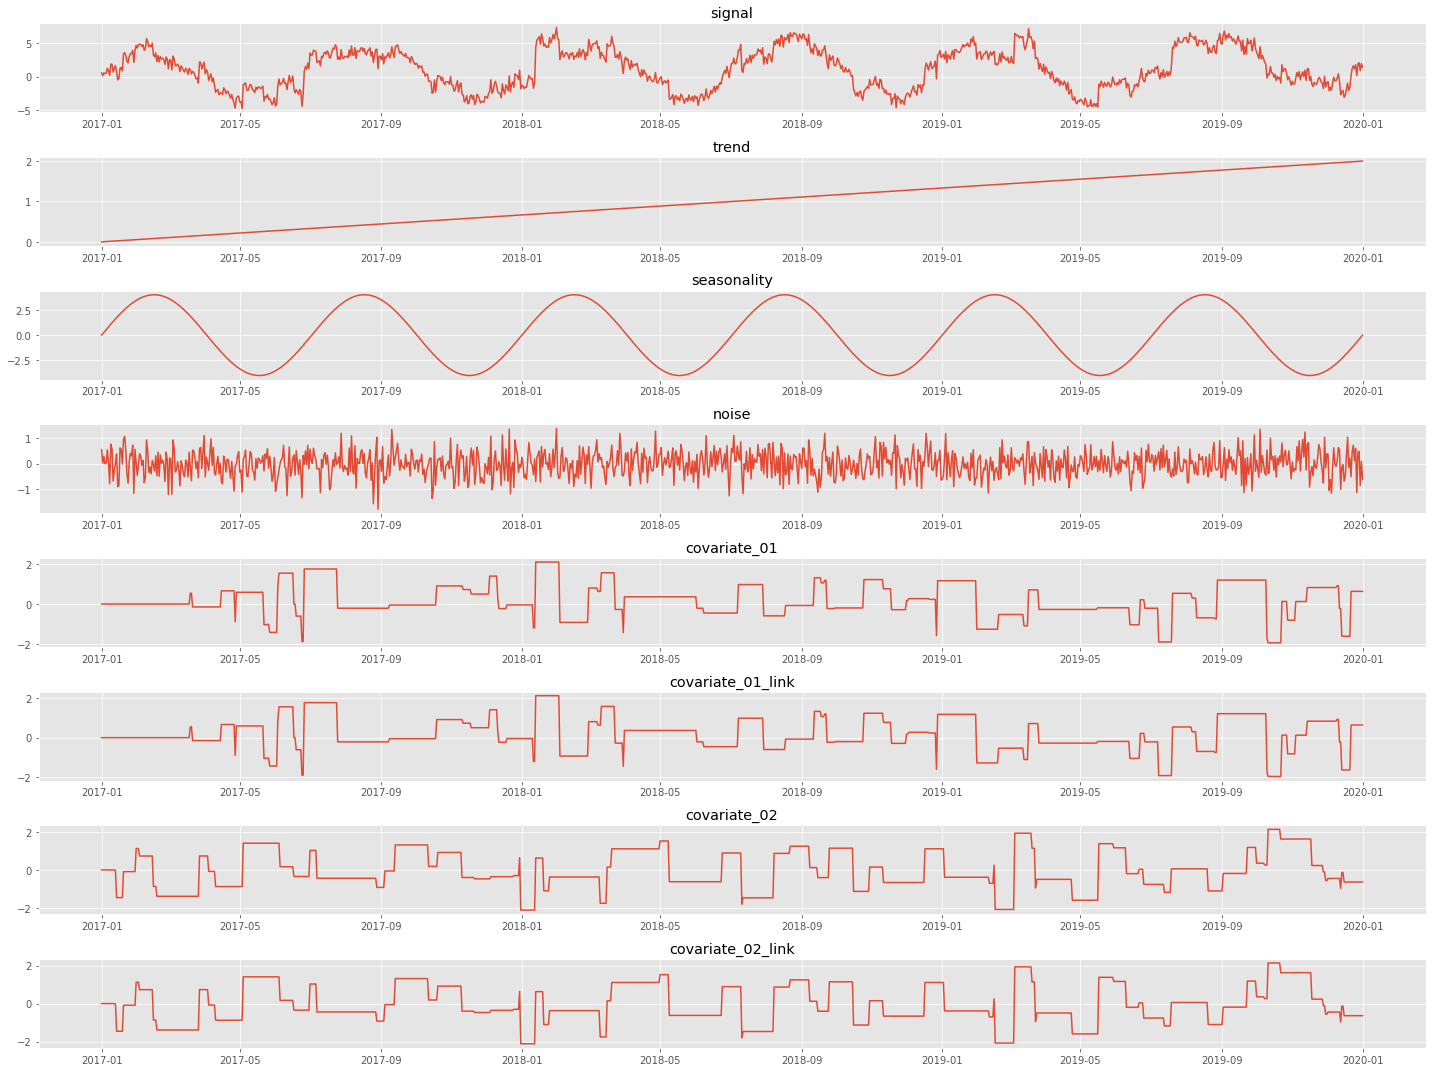

In [2]:
import numpy as np
import pandas as pd
import datetime
import collections
from matplotlib import pylab as plt
plt.style.use('ggplot')
import seaborn as sns
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
pd.options.mode.chained_assignment = None

import tensorflow as tf
from sklearn import preprocessing
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input 
from tensorflow.keras.layers import Lambda, RepeatVector, Permute, Flatten, Activation, Multiply
from tensorflow.keras.constraints import NonNeg
from tensorflow.keras import backend as K

from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
    
def step_series(n, mean, scale, n_steps):
    s = np.zeros(n)
    step_idx = np.random.randint(0, n, n_steps)
    value = mean
    for t in range(n):
        s[t] = value
        if t in step_idx:
            value = mean + scale * np.random.randn()
    return s

def linear_link(x): 
    return x

def mem_link(x, length = 50):
    mfilter = np.exp(np.linspace(-10, 0, length))
    return np.convolve(x, mfilter/np.sum(mfilter), mode='same')

def create_signal(links = [linear_link, linear_link]):
    days_year = 365
    quaters_year = 4
    days_week = 7
    
    # three years of data, daily resolution
    idx = pd.date_range(start='2017-01-01', end='2020-01-01', freq='D') 

    df = pd.DataFrame(index=idx, dtype=float)
    df = df.fillna(0.0)
    
    n = len(df.index)
    trend = np.zeros(n)
    seasonality = np.zeros(n)
    for t in range(n):
        trend[t] = 2.0 * t/n
        seasonality[t] = 4.0 * np.sin(np.pi * t/days_year*quaters_year)
    
    covariates = [step_series(n, 0, 1.0, 80), step_series(n, 0, 1.0, 80)]
    covariate_links = [ links[i](covariates[i]) for i in range(2) ]
    
    noise = 0.5 * np.random.randn(n)
    
    signal = trend + seasonality + np.sum(covariate_links, axis=0) + noise
    
    df['signal'], df['trend'], df['seasonality'], df['noise'] = signal, trend, seasonality, noise
    for i in range(2):
        df[f'covariate_0{i+1}'] = covariates[i]
        df[f'covariate_0{i+1}_link'] = covariate_links[i]
    
    return df

df = create_signal()
fig, ax = plt.subplots(len(df.columns), figsize=(20, 15))
for i, c in enumerate(df.columns):
    ax[i].plot(df.index, df[c])
    ax[i].set_title(c)

plt.tight_layout()
plt.show()

# Step 2: Define and Fit the Basic LSTM Model

We fit LSTM model that consumes patches of the observed signal and covariates, i.e. each input sample is a matrix where rows are time steps and columns are observed metrics (signal, covariate, and calendar features).

In [3]:
#
# engineer features and create input tensors
#
def prepare_features_rnn(df):        
    df_rnn = df[['signal', 'covariate_01', 'covariate_02']]
    df_rnn['year'] = df_rnn.index.year
    df_rnn['month'] = df_rnn.index.month
    df_rnn['day_of_year'] = df_rnn.index.dayofyear
    
    def normalize(df):
        x = df.values 
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(x)
        return pd.DataFrame(x_scaled, index=df.index, columns=df.columns)

    return normalize(df_rnn)
    
#
# train-test split and adjustments
#
def train_test_split(df, train_ratio, forecast_days_ahead, n_time_steps, time_step_interval): 

    # lenght of the input time window for each sample (the offset of the oldest sample in the input)
    input_window_size = n_time_steps*time_step_interval

    split_t = int(len(df)*train_ratio)
    x_train, y_train = [], []
    x_test, y_test = [], []
    y_col_idx = list(df.columns).index('signal')
    for i in range(input_window_size, len(df)):
        t_start = df.index[i - input_window_size]
        t_end = df.index[i]
        
        # we zero out last forecast_days_ahead signal observations, but covariates are assumed to be known
        x_t = df[t_start:t_end:time_step_interval].values.copy()
        if time_step_interval <= forecast_days_ahead:
            x_t[-int((forecast_days_ahead) / time_step_interval):, y_col_idx] = 0
        
        y_t = df.iloc[i]['signal']
            
        if i < split_t:
            x_train.append(x_t)
            y_train.append(y_t)
        else:
            x_test.append(x_t)
            y_test.append(y_t)       
    
    return np.stack(x_train), np.hstack(y_train), np.stack(x_test), np.hstack(y_test)

#
# parameters
#
n_time_steps = 40         # lenght of LSTM input in samples
time_step_interval = 2    # sampling interval, days
hidden_units = 8          # LSTM state dimensionality
forecast_days_ahead = 7
train_ratio = 0.8

#
# generate data and fit the model
#
df = create_signal()
df_rnn = prepare_features_rnn(df)
x_train, y_train, x_test, y_test = train_test_split(df_rnn, train_ratio, forecast_days_ahead, n_time_steps, time_step_interval)

print(f'Input tensor shape {x_train.shape}')

n_samples = x_train.shape[0]
n_features = x_train.shape[2]

input_model = Input(shape=(n_time_steps, n_features))
lstm_state_seq, state_h, state_c = LSTM(hidden_units, return_sequences=True, return_state=True)(input_model)
output_dense = Dense(1)(state_c)
model_lstm = Model(inputs=input_model, outputs=output_dense)

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
model_lstm.compile(loss='mean_squared_error',  metrics=['mean_absolute_percentage_error'], optimizer='RMSprop')
model_lstm.summary()
model_lstm.fit(x_train, y_train, epochs=20, batch_size=4, validation_data=(x_test, y_test), use_multiprocessing=True, verbose=1)
score = model_lstm.evaluate(x_test, y_test, verbose=0) 
print('Test MSE:', score[0]) 
print('Test MAPE:', score[1])

Input tensor shape (796, 41, 6)
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 6)]           0         
_________________________________________________________________
lstm (LSTM)                  [(None, 40, 8), (None, 8) 480       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 489
Trainable params: 489
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
199/199 [==============================] - 2s 9ms/step - loss: 0.0443 - mean_absolute_percentage_error: 135541.7031 - val_loss: 0.0111 - val_mean_absolute_percentage_error: 22.2035
Epoch 2/20
199/199 [==============================] - 1s 7ms/step - loss: 0.0134 - mean_absolute_percentage_error: 90105.8125 - val_loss: 0.0108 - val_mean_absolu

# Step 3: Visualize the Forecast and Evolution of the Hidden State

We first plot the forecast to show that models fits well. Next, we visualize how individual components of the hidden state evolve over time:
* We can see that some states actually extract seasonal and trend components, but this is not guaranteed. 
* We also overlay plots with covariates, to check if there are any correlation between states and covariates. We see that states do not correlate much with the covariate patterns.

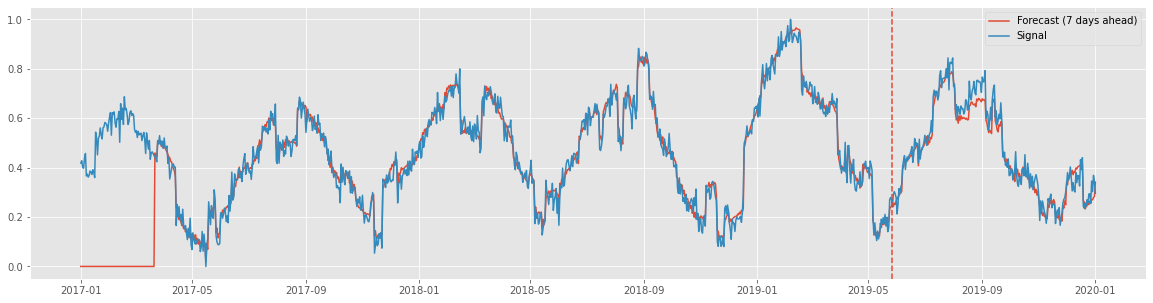

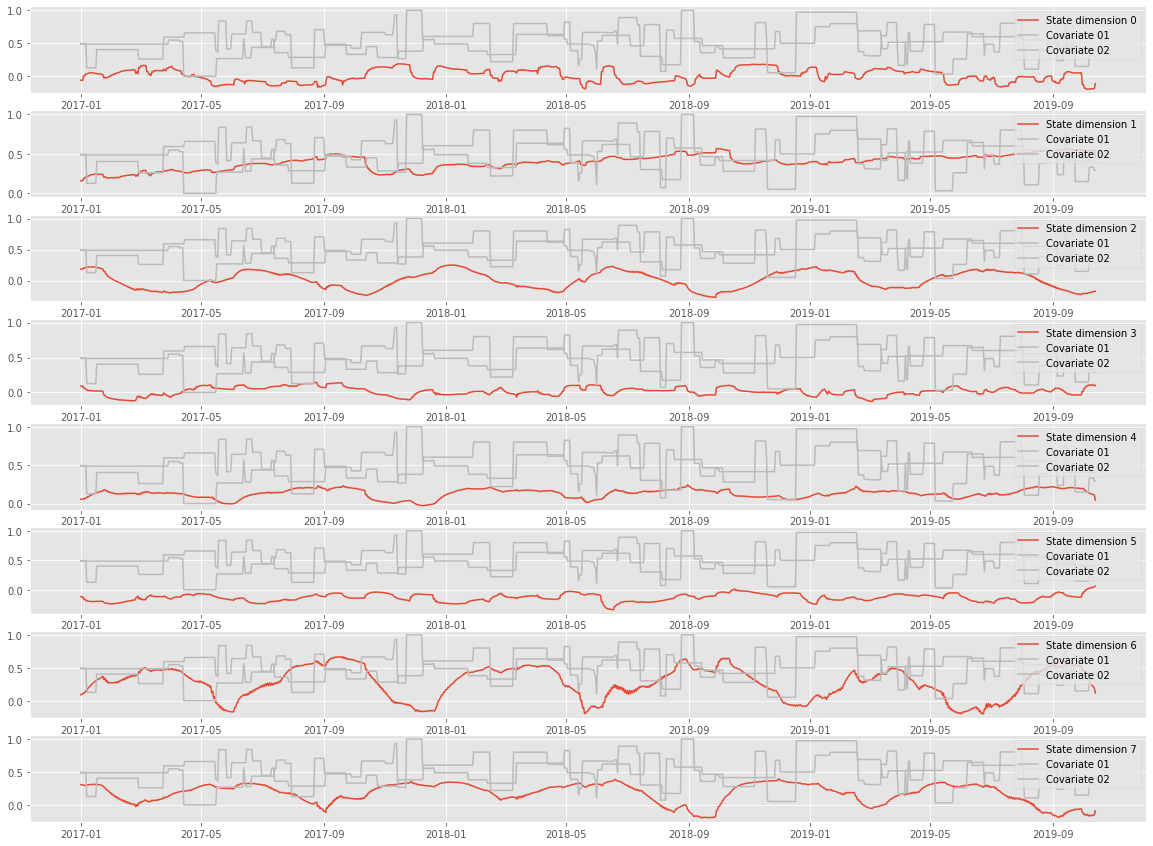

In [4]:
input_window_size = n_time_steps*time_step_interval
x = np.vstack([x_train, x_test])
y_hat = model_lstm.predict(x)
forecast = np.append(np.zeros(input_window_size), y_hat) 

#
# plot the forecast
#
fig, ax = plt.subplots(1, figsize=(20, 5))
ax.plot(df_rnn.index, forecast, label=f'Forecast ({forecast_days_ahead} days ahead)')
ax.plot(df_rnn.index, df_rnn['signal'], label='Signal')
ax.axvline(x=df.index[int(len(df) * train_ratio)], linestyle='--')
ax.legend()
plt.show()

#
# plot the evolution of the LSTM state 
#
lstm_state_tap = Model(model_lstm.input, lstm_state_seq)
lstm_state_trace = lstm_state_tap.predict(x)

state_series = lstm_state_trace[:, -1, :].T
fig, ax = plt.subplots(len(state_series), figsize=(20, 15))
for i, state in enumerate(state_series):
    ax[i].plot(df_rnn.index[:len(state)], state, label=f'State dimension {i}')
    for j in [1, 2]:
        ax[i].plot(df_rnn.index[:len(state)], df_rnn[f'covariate_0{j}'][:len(state)], color='#bbbbbb', label=f'Covariate 0{j}')

    ax[i].legend(loc='upper right')
plt.show()

# Step 4: Define and Fit LSTM with Attention (LSTM-A) Model

We fit the LSTM with attention model to analyze the contribution of individual time steps from input patches. It can help to reconstruct the (unknown) memory link function. 

In [5]:
#
# parameters
#
n_time_steps = 5         # lenght of LSTM input in samples
time_step_interval = 10    # sampling interval, days
hidden_units = 256         # LSTM state dimensionality
forecast_days_ahead = 14
train_ratio = 0.8

def fit_lstm_a(df, train_verbose = 0, score_verbose = 0):
    df_rnn = prepare_features_rnn(df)

    x_train, y_train, x_test, y_test = train_test_split(df_rnn, train_ratio, forecast_days_ahead, n_time_steps, time_step_interval)

    n_steps = x_train.shape[0]
    n_features = x_train.shape[2]

    #
    # define the model: LSTM with attention 
    #
    main_input = Input(shape=(n_steps, n_features))
    activations = LSTM(hidden_units, recurrent_dropout=0.1, return_sequences=True)(main_input)

    attention = Dense(1, activation='tanh')(activations)
    attention = Flatten()(attention)
    attention = Activation('softmax', name = 'attention_weigths')(attention)
    attention = RepeatVector(hidden_units * 1)(attention)
    attention = Permute([2, 1])(attention)

    weighted_activations = Multiply()([activations, attention])
    weighted_activations = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(hidden_units,))(weighted_activations)

    main_output = Dense(1, activation='sigmoid')(weighted_activations)

    model_attn = Model(inputs=main_input, outputs=main_output)

    #
    # fit the model
    #
    tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
    model_attn.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mean_absolute_percentage_error']) 
    history = model_attn.fit(x_train, y_train, batch_size=4, epochs=30, verbose=train_verbose, validation_data=(x_test, y_test)) 
    score = model_attn.evaluate(x_test, y_test, verbose=0) 
    if score_verbose > 0:
        print(f'Test MSE [{score[0]}], MAPE [{score[1]}]')

    return model_attn, df_rnn, x_train, x_test

df = create_signal(links = [linear_link, linear_link])
model_attn, df_rnn, x_train, x_test = fit_lstm_a(df, train_verbose = 1, score_verbose = 1)

Epoch 1/30
207/207 [==============================] - 3s 17ms/step - loss: 0.0531 - mean_absolute_percentage_error: 554625.5625 - val_loss: 0.0354 - val_mean_absolute_percentage_error: 51.5320
Epoch 2/30
207/207 [==============================] - 3s 16ms/step - loss: 0.0267 - mean_absolute_percentage_error: 415985.8125 - val_loss: 0.0247 - val_mean_absolute_percentage_error: 45.0028
Epoch 3/30
207/207 [==============================] - 3s 15ms/step - loss: 0.0194 - mean_absolute_percentage_error: 315432.1562 - val_loss: 0.0214 - val_mean_absolute_percentage_error: 43.1922
Epoch 4/30
207/207 [==============================] - 3s 15ms/step - loss: 0.0156 - mean_absolute_percentage_error: 210736.5000 - val_loss: 0.0192 - val_mean_absolute_percentage_error: 36.7590
Epoch 5/30
207/207 [==============================] - 3s 15ms/step - loss: 0.0150 - mean_absolute_percentage_error: 197102.4844 - val_loss: 0.0151 - val_mean_absolute_percentage_error: 30.5381
Epoch 6/30
207/207 [===============

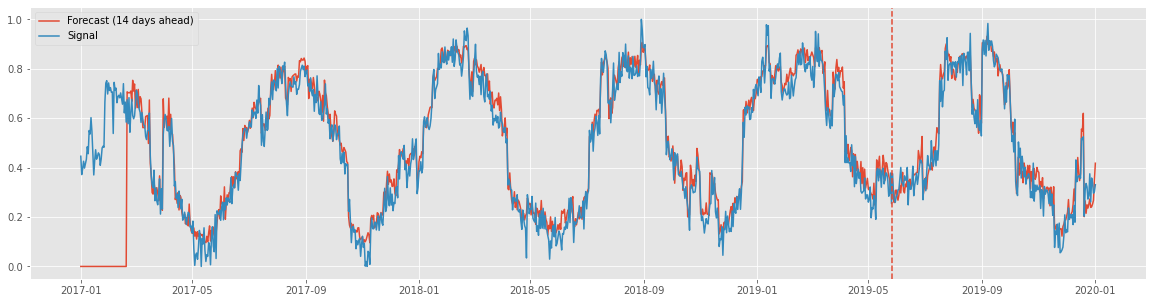

In [6]:
input_window_size = n_time_steps*time_step_interval
x = np.vstack([x_train, x_test])
y_hat = model_attn.predict(x)
forecast = np.append(np.zeros(input_window_size), y_hat) 

#
# plot the forecast
#
fig, ax = plt.subplots(1, figsize=(20, 5))
ax.plot(df_rnn.index, forecast, label=f'Forecast ({forecast_days_ahead} days ahead)')
ax.plot(df_rnn.index, df_rnn['signal'], label='Signal')
ax.axvline(x=df.index[int(len(df) * train_ratio)], linestyle='--')
ax.legend()
plt.show()

# Step 5: Analyze LSTM-A Model

The LSTM with attention model allows to extract the matrix of attention weights. For each time step, we have a vector of weights where each weight corresponds to one time step (lag) in the input patch.
* For the linear link, only the contemporaneous covariates/features have high contribution weights.
* For the memory link, the "LSTMogram" is more blurred becasue lagged samples have high contribution as well.

Weight matrix shape (826, 6)


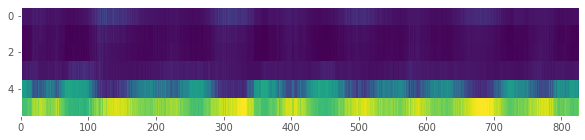

In [7]:
#
#  evaluate atention weights for each time step
#
attention_model = Model(inputs=model_attn.input, outputs=model_attn.get_layer('attention_weigths').output)
a = attention_model.predict(x_train)
print(f'Weight matrix shape {a.shape}')

fig, ax = plt.subplots(1, figsize=(10, 2))
ax.imshow(a.T, cmap='viridis', interpolation='nearest', aspect='auto')
ax.grid(None)

Evaluating LSTMogram for link [linear_link], trial [0]...
Evaluating LSTMogram for link [linear_link], trial [1]...
Evaluating LSTMogram for link [linear_link], trial [2]...
Evaluating LSTMogram for link [linear_link], trial [3]...
Evaluating LSTMogram for link [mem_link], trial [0]...
Evaluating LSTMogram for link [mem_link], trial [1]...
Evaluating LSTMogram for link [mem_link], trial [2]...
Evaluating LSTMogram for link [mem_link], trial [3]...


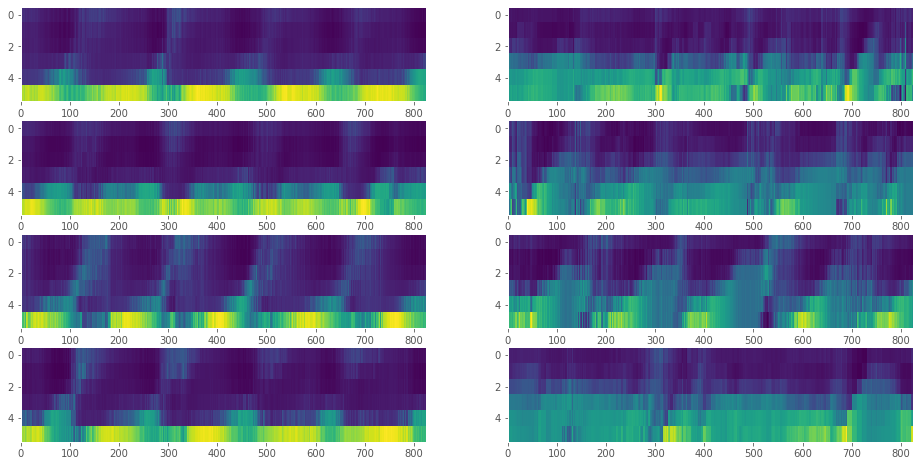

In [10]:
#
# generate multiple datasets and perform LSTM-A analysis for each of them
#
n_evaluations = 4
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
fig, ax = plt.subplots(n_evaluations, 2, figsize=(16, n_evaluations * 2))
for j, link in enumerate([linear_link, mem_link]):
    for i in range(n_evaluations):
        print(f'Evaluating LSTMogram for link [{link.__name__}], trial [{i}]...')
        df = create_signal(links = [link, link])
        model_attn, df_rnn, x_train, _ = fit_lstm_a(df, score_verbose = 0)
    
        attention_model = Model(inputs=model_attn.input, outputs=model_attn.get_layer('attention_weigths').output)
        a = attention_model.predict(x_train)
        ax[i, j].imshow(a.T, cmap='viridis', interpolation='nearest', aspect='auto')
        ax[i, j].grid(None)